<a href="https://colab.research.google.com/github/jpslaga/AI-Crash-Course/blob/master/Front_Door_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is a rough pass to get a baseline for how effective we can be at searching through the images in a listing and identifying which, if any, are a picture of the front of the house.

Frankly, this is a difficult challenge. The dataset is primarily composed of pictures of the outside of houses, but we are trying to find the ones that are the picture of the front of the house. It's one thing to classify one image as a bicycle and another a bannana, but these images are all very similar. To make things even harder, we only have 700 images of front doors to train on.

I modeled much of this code on this blog post: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Another great post: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

I wish I could remember where I got the data. Note to self, always cite your data source!! I think the original data source may have had photos from inside the house as well which might help the real production version deal with what it sees on Airbnb.

For now a copy of the data I used can be found on the shared drive in the demos folder. You can mount the drive using the controls on the left, or download the folder here: https://drive.google.com/drive/u/0/folders/1lTwGjUy9-MJtfnapxW-1ERT-p0Ius2Dc

The following code is written assuming that you mounted the shared drive.


In [ ]:
import numpy as np
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications


In [ ]:
img_width, img_height = 224, 224
raw_train_data_dir = '/content/drive/Shared drives/BI Share/demos/front_door_data/train_raw'
raw_validation_data_dir = '/content/drive/Shared drives/BI Share/demos/front_door_data/validate_raw'
nbr_train_samples = 4687
nbr_validation_samples = 1172
epochs = 20
batch_size = 128

In [ ]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss: Binary Crossentropy')
  plt.plot(history.epoch, np.array(history.history['loss']), label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']), label='Train Accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']), label = 'Val Accuracy')
  
  plt.legend()
  
  _, accuracy = model.evaluate(train_data, train_labels)
  print('Train Accuracy: %.2f' % (accuracy*100))
  _, accuracy = model.evaluate(validation_data, validation_labels)
  print('Validation Accuracy: %.2f' % (accuracy*100))

In [ ]:
# This is a data generator. It takes images as input and performs transformations for us.
# In this case we are using it to resize the images down to a much smaller size.
# This allows a smaller DNN to process the image, making the processing run faster.
datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_directory(
    raw_train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)
validation_generator = datagen.flow_from_directory(
    raw_validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 4687 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


# Transfer Learning

Transfer learning is a technique where you can take a DNN that has been trained on a great deal of data, and has already figured out a lot of basic tasks, and then use that knowledge to power a slightly different task. In this case, we will be taking some DNNs that were trained to recognize a variety of household objects, and will respecialize them to recognize front doors. They are already good at recognizing shapes, colors, and patters, we just need a new way to interpret the final results of all that image processing.

In [ ]:
# Load a pretrained model with the 'head' cut off. The output from this network will be an intermediate
# product, the result of the calculations from this DNN on the image, but no conclusion as to what
# to make of the image at the end.

# We are starting with the NASNetMobile DNN, which is fairly lightweight and high performance.
model = applications.NASNetMobile(include_top=False)

# Here we take the training data and run it through the loaded DNN. We save the output of
# this network and the labels to use as the input to a smaller, simpler network
# which sill only have the job of interpreting the results of the image processing
# and making a final decision about what the image represents.
train_data = model.predict(train_generator, nbr_train_samples)
train_labels = train_generator.labels

# Same treatment for the validation set, though one should not use
# data augmentation on validation data. You want the validation data
# to represent the task that will be seen in practice as closely as possible.
validation_data = model.predict(validation_generator, nbr_validation_samples)
validation_labels = validation_generator.labels

Epoch 1/20
37/37 [==============================] - 1s 38ms/step - loss: 0.2655 - accuracy: 0.8728 - val_loss: 0.1659 - val_accuracy: 0.9488
Epoch 2/20
37/37 [==============================] - 1s 33ms/step - loss: 0.1400 - accuracy: 0.9627 - val_loss: 0.1465 - val_accuracy: 0.9565
Epoch 3/20
37/37 [==============================] - 1s 33ms/step - loss: 0.1236 - accuracy: 0.9770 - val_loss: 0.1375 - val_accuracy: 0.9667
Epoch 4/20
37/37 [==============================] - 1s 33ms/step - loss: 0.1143 - accuracy: 0.9834 - val_loss: 0.1333 - val_accuracy: 0.9684
Epoch 5/20
37/37 [==============================] - 1s 33ms/step - loss: 0.1090 - accuracy: 0.9849 - val_loss: 0.1286 - val_accuracy: 0.9701
Epoch 6/20
37/37 [==============================] - 1s 33ms/step - loss: 0.1057 - accuracy: 0.9893 - val_loss: 0.1278 - val_accuracy: 0.9701
Epoch 7/20
37/37 [==============================] - 1s 33ms/step - loss: 0.1017 - accuracy: 0.9904 - val_loss: 0.1292 - val_accuracy: 0.9693
Epoch 8/20
37

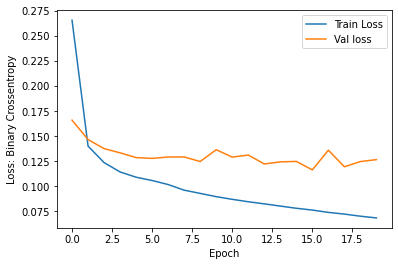

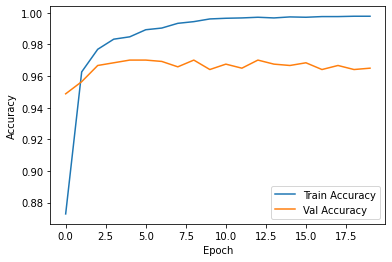

In [ ]:
# Here we build a small DNN that takes the output of the pretrained model as input, interprets it,
# and renders a final verdict about what to make of the image.
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

plot_history(history)

Now let's make two changes that might make this more accurate. Lets use a larger DNN for the image processing, and a larger DNN for interpreting the results.

In [ ]:
train_generator = datagen.flow_from_directory(
    raw_train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)
validation_generator = datagen.flow_from_directory(
    raw_validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 4687 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [ ]:
# Here we are trying out the VGG16 DNN which is somewhat larger and slower to process, but offers
# somewhat better accuracy than NASNetMobile on industry standard benchmarking tests.
model = applications.VGG16(include_top=False)

train_data = model.predict(train_generator, nbr_train_samples)
train_labels = train_generator.labels

validation_data = model.predict(validation_generator, nbr_validation_samples)
validation_labels = validation_generator.labels

Epoch 1/20
37/37 [==============================] - 3s 94ms/step - loss: 0.3273 - accuracy: 0.9042 - val_loss: 0.0973 - val_accuracy: 0.9625
Epoch 2/20
37/37 [==============================] - 4s 97ms/step - loss: 0.0574 - accuracy: 0.9774 - val_loss: 0.0764 - val_accuracy: 0.9701
Epoch 3/20
37/37 [==============================] - 3s 90ms/step - loss: 0.0313 - accuracy: 0.9895 - val_loss: 0.0687 - val_accuracy: 0.9761
Epoch 4/20
37/37 [==============================] - 3s 91ms/step - loss: 0.0185 - accuracy: 0.9953 - val_loss: 0.0759 - val_accuracy: 0.9744
Epoch 5/20
37/37 [==============================] - 4s 95ms/step - loss: 0.0103 - accuracy: 0.9987 - val_loss: 0.0675 - val_accuracy: 0.9753
Epoch 6/20
37/37 [==============================] - 3s 91ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0718 - val_accuracy: 0.9735
Epoch 7/20
37/37 [==============================] - 3s 91ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0705 - val_accuracy: 0.9761
Epoch 8/20
37

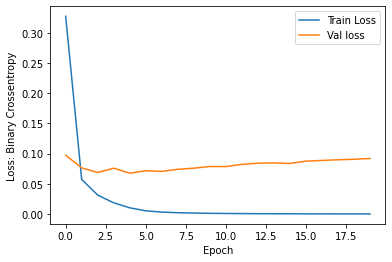

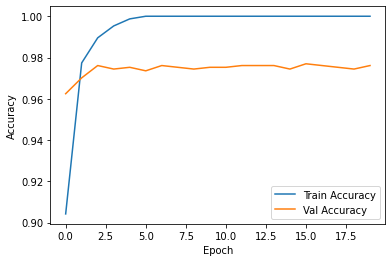

In [ ]:
# Here we build a somewhat larger DNN that takes the output of the pretrained model as input, interprets it,
# and renders a final verdict about what to make of the image.
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

plot_history(history)

There are a lot of lessons to be learned from this experience.

Bigger is not always better, and even if it is, suffers from diminishing returns.

The validation loss and accuracy had plateaued before 10 epochs were complete. After that, the validation loss actually gets worse over time. This is overfitting. We are getting better at guessing the training set, but getting worse when exposed to new data. The model has figured out that it can do better in the training exercises if it just memorizes the answers to these specific examples rather than learning generally applicable rules.

Notice that the loss gets worse for the validation set, while the accuracy remains stable. That's because accuracy only takes into account the binary value of whether the prediction was correct (True/False), while the loss measures just how much right or wrong the predictions were. If the actual value is 1, and the model outputs 0.49, it is wrong, but not **as** wrong as if it had output a 0.01. In this case, loss is the metric to watch.

We have already covered some techniques for dealing with overfitting, but we will continue to address the issue as we go.

# Data Augmentation

Now, let's see if we can make more of the data we have. We can use the images we have to generate some similar images that we might see. For instance, maybe we would see images under different lighting conditions, or rotated slightly however the photographer was holding the camera, or with things slightly off-center, or otherwise slightly different than what we have here. Keras has built-in functionality to make this easy.

In [ ]:
augment_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest',
        brightness_range=(0.5, 1.5)
      )
train_generator = augment_datagen.flow_from_directory(
    raw_train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)
# Note that we are using the non-augmented data generator for the validation dataset
validation_generator = datagen.flow_from_directory(
    raw_validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 4687 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [ ]:
# Let's go back to the smaller model for faster runtimes.
model = applications.NASNetMobile(include_top=False)

# Notice that we are looping over the training data 10 times taking different augmentations.
# This increased data volume should help our training efforts.
train_data = model.predict(train_generator, nbr_train_samples*10)
train_labels = train_generator.labels

validation_data = model.predict(validation_generator, nbr_validation_samples)
validation_labels = validation_generator.labels

Epoch 1/20
37/37 [==============================] - 2s 46ms/step - loss: 0.5013 - accuracy: 0.8291 - val_loss: 0.1935 - val_accuracy: 0.9019
Epoch 2/20
37/37 [==============================] - 2s 42ms/step - loss: 0.2667 - accuracy: 0.8628 - val_loss: 0.1616 - val_accuracy: 0.9326
Epoch 3/20
37/37 [==============================] - 2s 43ms/step - loss: 0.2311 - accuracy: 0.8713 - val_loss: 0.1561 - val_accuracy: 0.9411
Epoch 4/20
37/37 [==============================] - 2s 43ms/step - loss: 0.1959 - accuracy: 0.8899 - val_loss: 0.1293 - val_accuracy: 0.9616
Epoch 5/20
37/37 [==============================] - 2s 44ms/step - loss: 0.1773 - accuracy: 0.9025 - val_loss: 0.1163 - val_accuracy: 0.9650
Epoch 6/20
37/37 [==============================] - 2s 43ms/step - loss: 0.1589 - accuracy: 0.9215 - val_loss: 0.1234 - val_accuracy: 0.9539
Epoch 7/20
37/37 [==============================] - 2s 43ms/step - loss: 0.1444 - accuracy: 0.9249 - val_loss: 0.1100 - val_accuracy: 0.9608
Epoch 8/20
37

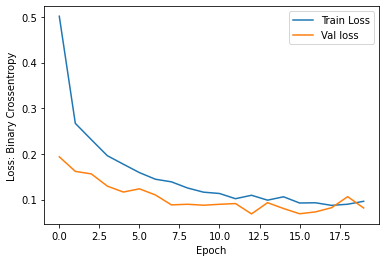

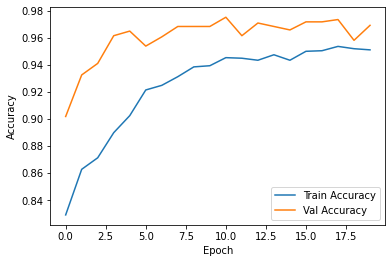

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

plot_history(history)

You might have noticed that our validation set has a lower loss and higher accuracy than our training set. How could we be performing better on the validation set, which the model has not seen, than we are doing on the training set? The answer is that while testing performance Keras uses dropout for the training data, but not for the validation data. This mimics what we would do in production. We use dropout while training the model, but when we deploy the model we want it to use all it's neurons at full power. Because the model is hamstringed on the training data it doesn't perform as well, even though it is the data it has seen before.

# Conclusion

While things will fluctuate from run to run, in my run I got a validation accuracy of 96.50%, not bad for a quick and dirty model on a highly challenging problem! Adding some dropout regularization and data augmentation took that model up to 96.93%. That's almost half a percent improved performance with some extra training-time effort to create a model that processes data just as fast. The larger, slower, VGG16 model performed the best with an accuracy on the validation set of 97.61%.

All of this was done with about two hours of processing time on the free service provided by colab. Everything for free, an afternoon of coding, and two hours processing and a very difficult image processing problem is all but solved!

# Next Steps
There are several ways we could try to make this model better.

For one, you could try out some different image processing DNNs. There are lots available. For a list of the ones available as part of the Keras applications package we were using here see: https://keras.io/api/applications/

.

You could try out different sizes and shapes of DNNs for interpreting the results of the output of the image processing DNN. That includes trying different activation functions, optimizers, learning rates, and regularization. I used a generic dropout here, but you could try different dropout approaches, and or use L2 or other regularization techniques. I got the best results with the VGG16 model, but is that improved performance due to better image processing from the VGG16 model, or from the larger DNN I used to interpret the results?

.

You could try finding more data to train with. I'm not sure I included all the original data in this example (though since I didn't remember to cite my data source I can't be sure). There might also be other data sets we could add to this one, or you could even go to Airbnb and download images yourself.

.

You could try different data augmentation strategies. I tried one setting here, but what happens if we try others?

.

I leave the exploration as an exercise for the student. If you do choose to pursue this, please let us know. We plan to build this as a production system near the beginning of 2021, and would love to know ahead of time what works well and what's a dead end.